In [133]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split


In [134]:
TrainingColums = ["nTracks","B_P","gamma_PT","Kst_892_0_PT","B_Cone3_B_ptasy","B_ETA"]

sharedColums = ["nTracks","B_P","gamma_PT","B_Cone3_B_ptasy", 
                "B_ETA", "B_MINIPCHI2","B_SmallestDeltaChi2OneTrack",
                "B_FD_OWNPV","piminus_PT", "piminus_IP_OWNPV"]


columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT","Kst_892_0_IP_OWNPV","Kplus_PT", "Kplus_IP_OWNPV" ],
              "pipi" : sharedColums + ["rho_770_0_PT","rho_770_0_IP_OWNPV","piplus_PT","piplus_IP_OWNPV"]}


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"blue" : "#066bd6", "red" : "#d60645",  "pink" : "#2fad66", "green":"#2fad66","black":"#000000"}

In [135]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
    pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
    pipi_up_MC_df        = pipi_TTree_MC_up.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
    pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
    pipi_down_MC_df      = pipi_TTree_MC_down.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)


#Add min() colum to the dataframe
dataframes["kpi"  ]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpi"  ]["Kplus_IP_OWNPV"]),list(dataframes["kpi"  ]["piminus_IP_OWNPV"])) ]
dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpisw"]["Kplus_IP_OWNPV"]),list(dataframes["kpisw"]["piminus_IP_OWNPV"])) ]

columns["kpi" ].append("min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" )
columns["pipi"].append("min(piminus_IP_OWNPV,piplus_IP_OWNPV)")

for var in columns["kpi"]:
    dataframes["kpi"  ][f"log({var})"] = np.nan_to_num( np.log(dataframes["kpi"  ][var]) )
    dataframes["kpisw"][f"log({var})"] = np.nan_to_num( np.log(dataframes["kpisw"][var]) )
    
print("Data has been loaded")

/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data has been loaded


In [136]:
dataframes["kpi"]

,nTracks,B_P,gamma_PT,B_Cone3_B_ptasy,B_ETA,B_MINIPCHI2,B_SmallestDeltaChi2OneTrack,B_FD_OWNPV,piminus_PT,piminus_IP_OWNPV,...,log(B_MINIPCHI2),log(B_SmallestDeltaChi2OneTrack),log(B_FD_OWNPV),log(piminus_PT),log(piminus_IP_OWNPV),log(Kst_892_0_PT),log(Kst_892_0_IP_OWNPV),log(Kplus_PT),log(Kplus_IP_OWNPV),"log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"
0,60,273883.848744,7018.973127,0.660959,3.587485,0.392829,17.547800,7.153876,2298.157129,0.195850,...,-0.934380,2.864929,1.967654,7.739863,-1.630408,9.021615,-2.077442,8.696341,-2.278567,-2.278567
1,60,273883.848744,7018.973127,0.660959,3.587485,0.392829,17.547800,7.153876,5980.988377,0.102431,...,-0.934380,2.864929,1.967654,8.696341,-2.278567,9.021615,-2.077442,7.739863,-1.630408,-2.278567
2,107,126785.577724,7158.783755,0.543079,3.211112,2.893996,313.574890,13.858021,2188.554096,1.494048,...,1.062638,5.748038,2.628864,7.690996,0.401489,8.059657,0.132202,6.894570,-0.490724,-0.490724
3,131,100415.996715,6545.822352,0.551857,2.554097,8.310109,84.313843,10.304591,4558.507548,0.412559,...,2.117473,4.434546,2.332590,8.424751,-0.885376,9.185044,-0.946742,8.555185,-0.931879,-0.931879
4,131,100415.996715,6545.822352,0.551857,2.554097,8.310109,84.313843,10.304591,5193.613137,0.393813,...,2.117473,4.434546,2.332590,8.555185,-0.931879,9.185044,-0.946742,8.424751,-0.885376,-0.931879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105804,243,84931.574490,3954.462812,0.587744,2.321838,0.451742,12.087173,5.578162,6277.329459,0.250190,...,-0.794644,2.492145,1.718859,8.744700,-1.385535,9.492644,-1.545086,8.853083,-1.681706,-1.681706
105805,189,136018.777381,6168.203203,0.083082,3.217236,2.407127,7.364946,18.615648,1463.252400,0.461360,...,0.878434,1.996732,2.924003,7.288417,-0.773576,8.550305,-0.516956,8.217706,-0.421101,-0.773576
105806,189,136018.777381,6168.203203,0.083082,3.217236,2.407127,7.364946,18.615648,3705.990062,0.656324,...,0.878434,1.996732,2.924003,8.217706,-0.421101,8.550305,-0.516956,7.288417,-0.773576,-0.773576
105807,206,77078.946405,5078.961409,-0.097834,2.489899,2.150364,3.362027,4.061175,6856.574867,0.196109,...,0.765637,1.212544,1.401472,8.832963,-1.629084,9.046140,-1.567287,7.399253,-1.254311,-1.629084


In [137]:
# divide original samples into training ant test parts
kpiMC_train, kpiMC_test = train_test_split(dataframes["kpi"])
# divide target samples into training ant test partss
kpiSW_train, kpiSW_test = train_test_split(dataframes["kpisw"])

kpiMC_weights_train = np.ones(len(kpiMC_train))
kpiMC_weights_test  = np.ones(len(kpiMC_test))

kpiSW_weights_train = kpiSW_train["NB0_Kpigamma_sw"]
kpiSW_weights_test  = kpiSW_test["NB0_Kpigamma_sw"]
print("Data has been Split")


Data has been Split


In [145]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=250,  learning_rate=0.02, max_depth=4, min_samples_leaf=1000, gb_args={'subsample': 0.4})
GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=4)
GradientBoostedReweighter.fit(kpiMC_train[TrainingColums], kpiSW_train[TrainingColums], original_weight=kpiMC_weights_train, target_weight=kpiSW_weights_train)

FittedWeights_test  = GradientBoostedReweighter.predict_weights(kpiMC_test[ TrainingColums])
FittedWeights_train = GradientBoostedReweighter.predict_weights(kpiMC_train[TrainingColums])

KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using folds column


In [146]:
def Chi2OfHistograms(hist_reweighted, hist_target):
    chiSquared = 0
    for bin in range(0, len(hist_reweighted)):

            chiSquared += abs(hist_reweighted[bin] - hist_target[bin])

    return chiSquared

In [150]:

def CreateLargeCanvasOfDoublePlots():

    PlotingColums = np.array( ["nTracks","log(B_P)", "gamma_PT","log(Kst_892_0_PT)", "B_Cone3_B_ptasy", "B_ETA", 
                               "log(B_MINIPCHI2)", "log(B_SmallestDeltaChi2OneTrack)", "log(B_FD_OWNPV)", "B_FD_OWNPV", "log(piminus_IP_OWNPV)",
                               "log(Kst_892_0_IP_OWNPV)", "Kplus_PT", "piminus_PT", "log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"] )
    
    PlotingLabels =  np.array( ["nTracks","log(B_P)", "gamma_PT","log(Kst_PT)", "B_Cone3_B_ptasy", "B_ETA", 
                               "log(B_MINIPCHI2)", "log(B_SmallestChi2)", "log(B_FD_OWNPV)", "B_FD_OWNPV", "log(piminus_IP_OWNPV)",
                               "log(Kst_IP_OWNPV)", "Kplus_PT", "piminus_PT", "log(min(IP_OWNPV))"])
    
    canvas, axes = plt.subplots(3,5,figsize=(25, 10))
    canvas.tight_layout()
    index = 0
    Chi_change_test  = 0
    KS_change_train = 0

    for ax in axes.flat:

        variable = PlotingColums[index]
        label    = PlotingLabels[index]
        
        hist_kpi_y,   hist_kpi_x,   _  = ax.hist(  [kpiMC_test[variable], kpiSW_test[variable], kpiMC_test[variable]], 
                                         weights = [kpiMC_weights_test,   kpiSW_weights_test,   FittedWeights_test], 
                                         color   = [colors["blue"],       colors["red"],        colors["green"]], 
                                         label   = ["Kpi MC",             "Kpi Sample",         "Kpi MC Reweighted"], 
                                         **hist_style )
        
        index += 1

        Chi_Before_test   = Chi2OfHistograms(hist_kpi_y[0],hist_kpi_y[1])
        Chi_After_test    = Chi2OfHistograms(hist_kpi_y[2],hist_kpi_y[1])
        Chi_change_test  += ((Chi_Before_test / Chi_After_test)  - 1)
 
        ax.set_title(f"{label}, Test : {np.round((Chi_Before_test/Chi_After_test - 1)*100,2)}%")

    MeanChi_test  = (Chi_change_test / len(PlotingColums))*100

    print(f"Mean Improvement: {np.round(MeanChi_test,1)}%")

    canvas.savefig("../imgs/superCanvas.png")

Mean Improvement: 51.6%


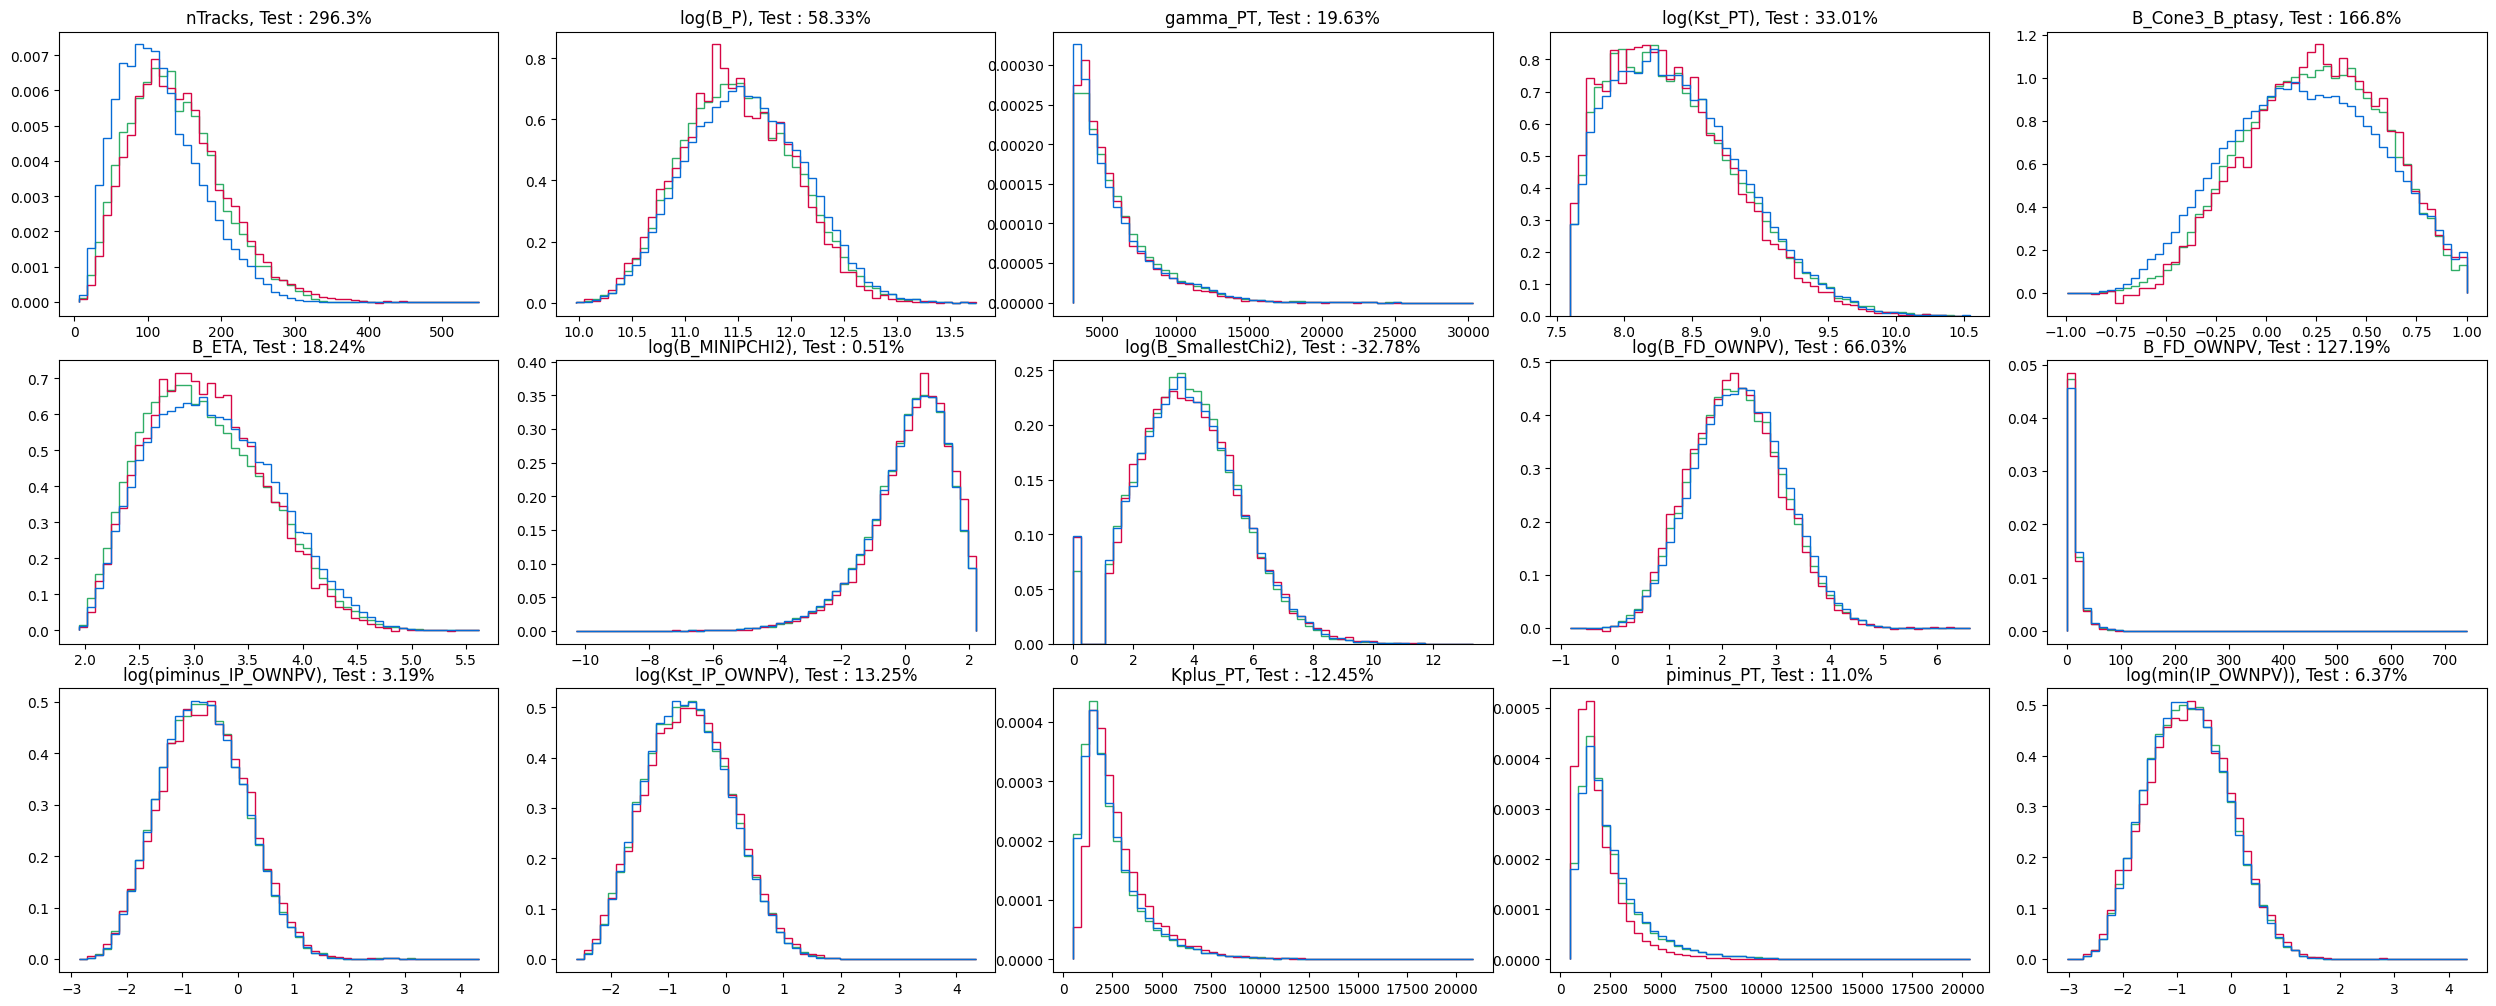

In [151]:
CreateLargeCanvasOfDoublePlots()

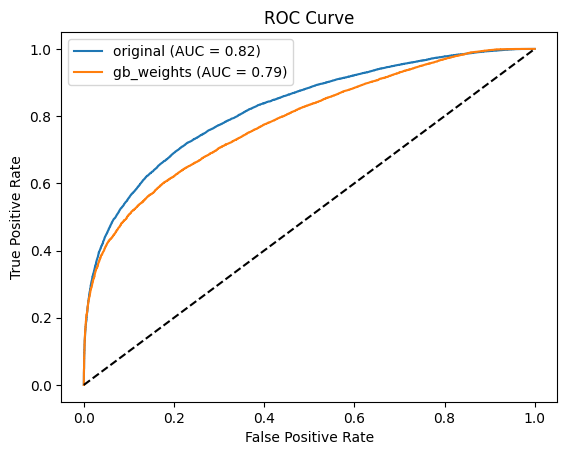

In [149]:
#TODO - Implement ROC curve

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

data   = np.concatenate([kpiMC_test, kpiSW_test.drop(labels="NB0_Kpigamma_sw", axis=1)])
labels = np.array([0] * len(kpiMC_test) + [1] * len(kpiSW_test))

weights = {}
weights["original"]   = kpiMC_weights_test
weights["gb_weights"] = FittedWeights_test


for name, new_weights in weights.items():


    W = np.concatenate([new_weights / new_weights.sum() * len(kpiSW_test), [1] * len(kpiSW_test)])
    
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)

    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    y_pred_proba = clf.predict_proba(Xts)[:, 1]
    auc_score = roc_auc_score(Yts, y_pred_proba, sample_weight=Wts)
    # Added calculation of fpr, tpr, and thresholds
    fpr, tpr, thresholds = roc_curve(Yts, y_pred_proba, sample_weight=Wts)
    # Added plotting of the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Added diagonal line for random classifier
plt.xlabel("False Positive Rate")  # Added x-axis label
plt.ylabel("True Positive Rate")  # Added y-axis label
plt.title("ROC Curve")  # Added title
plt.legend()  # Added legend
plt.show()  # Added show plot
